## STEPS

Step 1: Understanding the Dataset
First, loading the dataset and explore its structure to understand what information it contains. This will help us in generating event logs and visualizations.

Step 2: Generating Event Logs
We'll create event logs from the dataset. Event logs typically capture the sequence of events (or actions) for each patient, along with timestamps. These logs are crucial for process mining.

Step 3: Visualizing Actions Between January 2017 and June 2017
We'll filter the dataset to focus on the specified time range and then visualize the actions taken in the hospital during that period.

Step 4: Process Mining
Using appropriate process mining algorithms, we'll analyze the flow of actions undertaken at the hospital. This will help in understanding the overall process and identifying any patterns or bottlenecks.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pm4py
import pyvis

## TASK 1
### 1. Generate the event logs for the above dataset and save them as Question 2.


#### Load the data and display the head.  The data-set is composed of 4 columns, "patient", "datetime", "action", "resource".  I renamed them from their original names to make the dataset easier to read, and converted the datetime to a timestamp.

In [3]:
patients = pd.read_csv("ArtificialPatientTreatment.csv")

In [4]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   patient        690 non-null    object
 1    action        690 non-null    object
 2    org:resource  690 non-null    object
 3    DateTime      690 non-null    object
dtypes: object(4)
memory usage: 21.7+ KB


In [5]:
patients.head()

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [6]:
# Fix column names
patients["datetime"] = pd.to_datetime(patients[' DateTime'])
patients["action"]   = patients[" action"]
patients["resource"] = patients[" org:resource"]
patients = patients.drop([" DateTime", " action", " org:resource"], axis=1)

patients.head()

,patient,datetime,action,resource
0,patient 0,2017-01-02 11:40:11,First consult,Dr. Anna
1,patient 0,2017-01-02 12:47:33,Blood test,Lab
2,patient 0,2017-01-02 12:53:50,Physical test,Nurse Jesse
3,patient 0,2017-01-02 16:21:06,Second consult,Dr. Anna
4,patient 0,2017-01-05 13:23:09,Surgery,Dr. Charlie


saving the event logs as Question 2

In [8]:
# Define the path where you want to save the event log
event_log_path = r'D:\DATA MINING FINAL PROJECT\FINAL-PROJECT-DATA-MINING\Question_2_EventLog.csv'

# Save the event logs
patients.to_csv(event_log_path, index=False)

print(f"Event logs saved to: {event_log_path}")


Event logs saved to: D:\DATA MINING FINAL PROJECT\FINAL-PROJECT-DATA-MINING\Question_2_EventLog.csv


FURTHER ANALYSIS 

### Creating the duration for the patient, and create a relative time in seconds and days
#### Just to find out how long it takes for cases 

In [5]:
# Create a pivot table of the start (minimum) and end (maximum) timestamps associated with each case:
case_starts_ends = patients.pivot_table(index="patient", aggfunc={"datetime": ["min", "max"]})
case_starts_ends = case_starts_ends.reset_index() 
case_starts_ends.columns = ['patient', 'caseend', 'casestart']

# Merge with the main event log data so that for each row we have the start and end times.
patients = patients.merge(case_starts_ends, on='patient') 

# Calculate the relative time by subtracting the process start time from the event timestamp
patients['relativetime'] = patients['datetime'] - patients['casestart']

# Convert relative times to more friendly measures
patients['relativetime_s'] = patients['relativetime'].dt.seconds + 86400*patients['relativetime'].dt.days ## seconds
patients['relativedays'] = patients['relativetime'].dt.days ## days

# Append the case length
patients["caselength"] = patients["caseend"] - patients["casestart"]

patients.head()

,patient,datetime,action,resource,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,2017-01-02 11:40:11,First consult,Dr. Anna,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,2017-01-02 12:47:33,Blood test,Lab,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,2017-01-02 12:53:50,Physical test,Nurse Jesse,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,2017-01-02 16:21:06,Second consult,Dr. Anna,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,2017-01-05 13:23:09,Surgery,Dr. Charlie,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17


## TASK 2
### Generate a visual showing “actions” undertaken at the hospital between January 2017 and June 2017. 

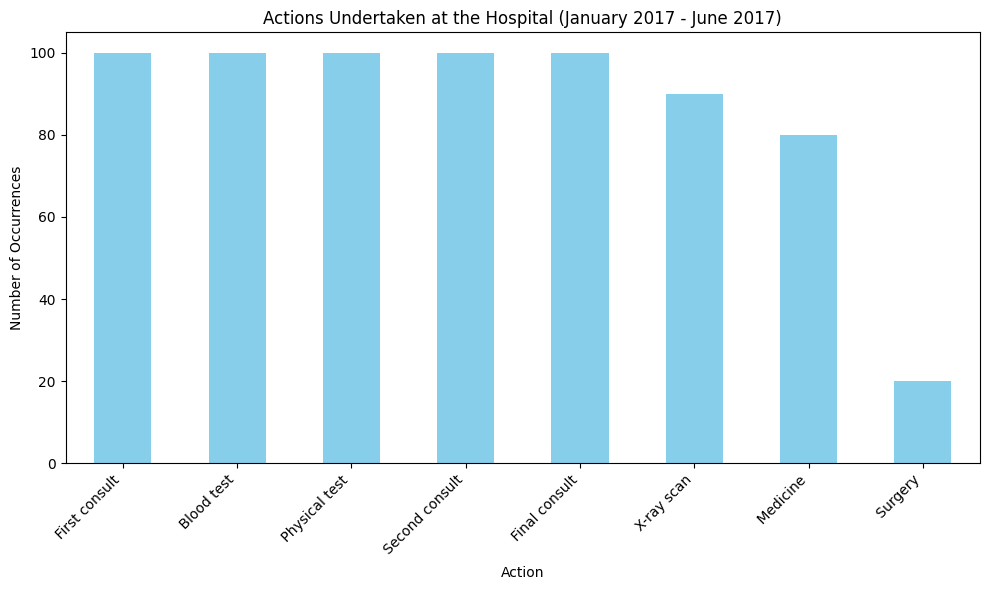

In [10]:
# Filter data for the period between January 2017 and June 2017
filtered_df = patients[(patients['datetime'] >= '2017-01-01') & (patients['datetime'] <= '2017-06-30')]

# Group by action and count occurrences
action_counts = filtered_df['action'].value_counts()

# Plot the distribution of actions
plt.figure(figsize=(10, 6))
action_counts.plot(kind='bar', color='skyblue')
plt.title('Actions Undertaken at the Hospital (January 2017 - June 2017)')
plt.xlabel('Action')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## TASK 3
### Using appropriate process mining algorithms, show the flow of “actions” undertaken at the hospital.

## The dotted chart

### To get an initial feel for what processes ‘look like’, it is useful to visualise the events associated with each case over (relative) time. This can be done with a dotted chart. we can implement this using a scatter plot or strip plot, which plots the event sequences of each case against time.

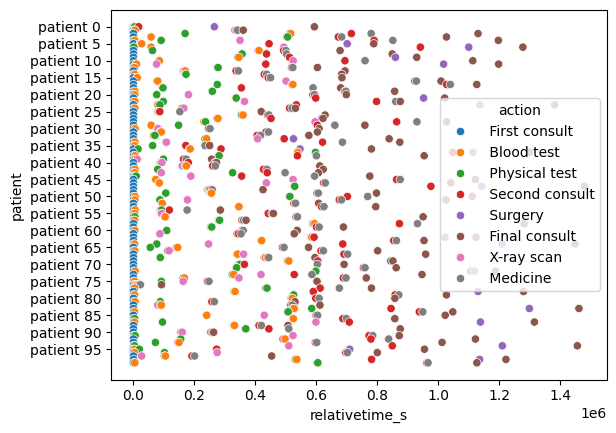

In [6]:
## Get an array of patient labels for the y axis - for graph labelling purposes
patientnums = [int(e) for e in patients['patient'].apply(lambda x: x.strip('patient'))]

## Plot a scatter plot of patient events over relative time
ax = sns.scatterplot(x=patients['relativetime_s'],
y = patients['patient'], hue=patients['action'])

## Set y axis ticks so that you only show every 5th patient - for readability
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5))

plt.show()

### This is quite difficult to read. To make the plot easier to read, we should order the cases by overall process lengths. This also gives you a better feel for the distribution of process durations.

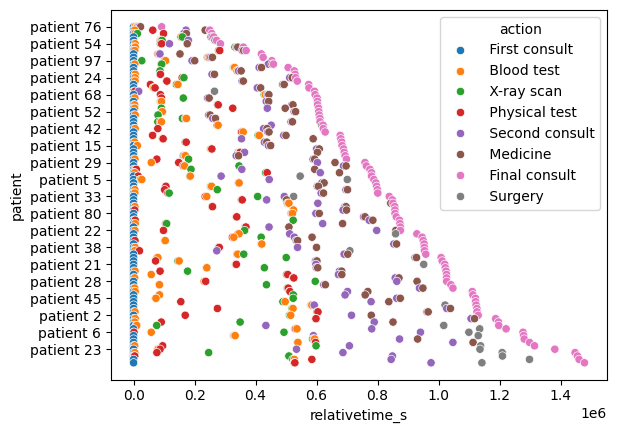

In [7]:
## Order by the case length
ordered = patients.sort_values(by=['caselength', 'patient', 'relativetime_s'])

ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered['action']) 
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5))
plt.show()

### The dotted chart can also be used to get an idea of the event flow over absolute time, e.g. if cases are coming in regularly, if there are weekly or daily trends.

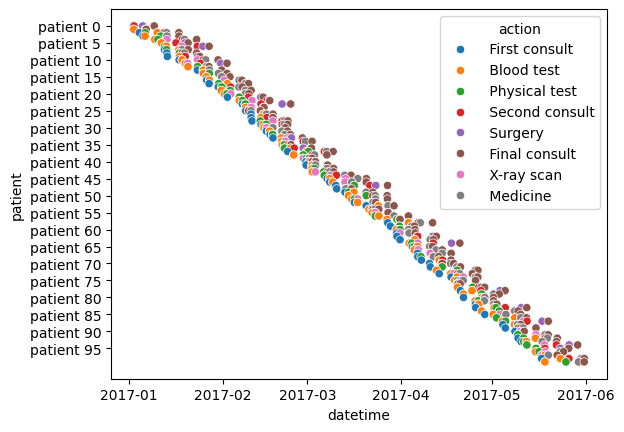

In [8]:
ax = sns.scatterplot(x=patients['datetime'], y=patients['patient'], hue=patients['action']) 
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5))
plt.show()

### This shows a steady flow of cases over time.

#### We can also study events with respect to the resources by plotting events with respect to date and time

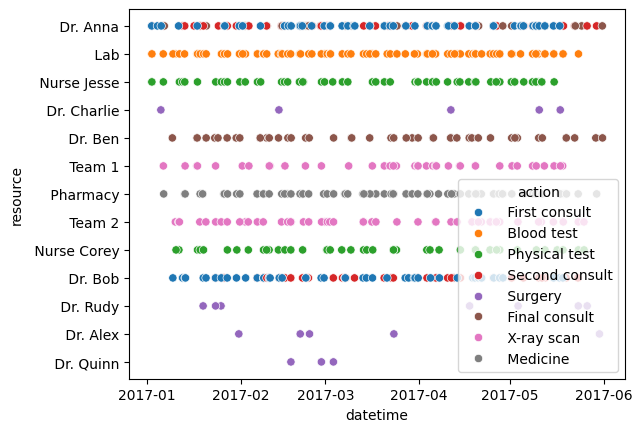

In [9]:
ax = sns.scatterplot(x=patients['datetime'], y=patients['resource'], hue=patients['action'])

### To investigate weekly trends, we first need to convert the time stamps into days of the week.  Then we can use a jitter plot rather than a strip plot because the x axis (day of week) is categorical.

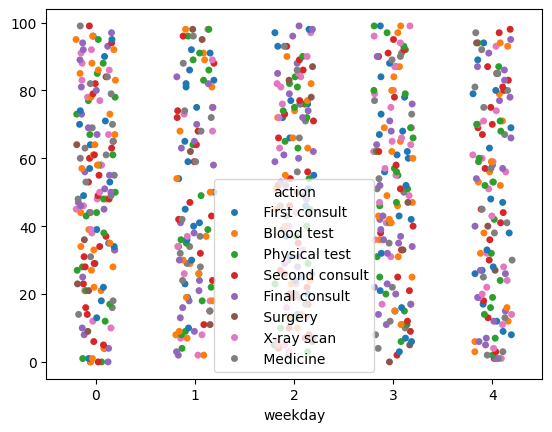

In [10]:
## Get day of week 
patients['weekday'] = patients['datetime'].apply(lambda x: x.weekday())

## Strip plot
ax = sns.stripplot(x=patients['weekday'], y=patientnums, hue=patients['action'], jitter=0.2)

## Filtering events
### One final thing we want to look at is which events are shared by all processes and which are not, since in process mining it is the non-shared differentiating events that we are interested in

The following actions are common to all cases:  Blood test,  Final consult,  First consult,  Physical test,  Second consult
The following actions are the ones that we wish to keep (not common to all cases):  Medicine,  Surgery,  X-ray scan


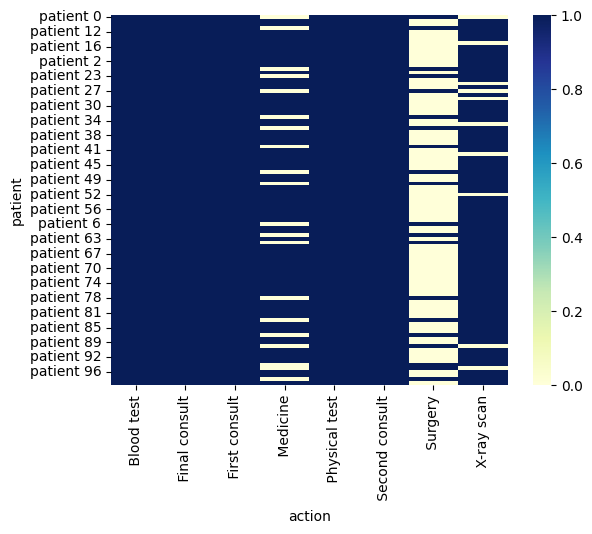

In [11]:
## Create a table giving the number of cases in which each event is present.
patient_events = pd.crosstab(patients['patient'], patients['action'])

## Visualise in a heatmap
sns.heatmap(patient_events, cmap="YlGnBu")

## Calculate the number of unique event counts 
## This should be 1 for events which are shared by all patients.
nunique = patient_events.apply(pd.Series.nunique) 

## Identify the events which are shared by all 
shared_actions = nunique[nunique==1].index 
actions_to_keep = nunique[nunique>1].index

print('The following actions are common to all cases: {}'.format(', '.join(shared_actions))) 
print('The following actions are the ones that we wish to keep (not common to all cases): {}'.format(', '.join(actions_to_keep)))

### using the pm4py to collect our starting activities

In [12]:
## Retrieve our start activities
start_activities = pm4py.get_start_activities(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
start_activities

{' First consult': 100}

### Using pm4py to collect all of the end activities

In [13]:
## Retrieve our end activities
end_activities = pm4py.get_end_activities(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
end_activities

{' Final consult': 100}

### Identify how many times each of the different activities occur, and how many times each of our resources get utilized

In [16]:
## Get a list of all of our actvities
print(f"""The number of different activities in our dataset are: 
{pm4py.get_event_attribute_values(patients, 'action', case_id_key='patient')} 
""")

## Get a list of all of our resources
print(f"""The number of times our different resources are used in our dataset are: 
{pm4py.get_event_attribute_values(patients, 'resource', case_id_key='patient')}""")

The number of different activities in our dataset are: 
{' First consult': 100, ' Blood test': 100, ' Physical test': 100, ' Second consult': 100, ' Final consult': 100, ' X-ray scan': 90, ' Medicine': 80, ' Surgery': 20} 

The number of times our different resources are used in our dataset are: 
{' Dr. Anna': 158, ' Lab': 100, ' Dr. Bob': 92, ' Pharmacy': 80, ' Nurse Jesse': 57, ' Dr. Ben': 50, ' Team 2': 50, ' Nurse Corey': 43, ' Team 1': 40, ' Dr. Rudy': 7, ' Dr. Charlie': 5, ' Dr. Alex': 5, ' Dr. Quinn': 3}


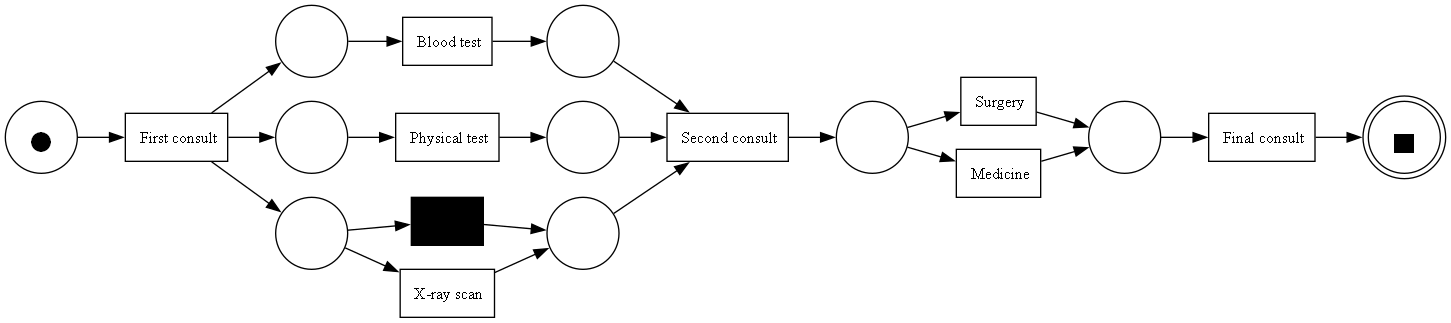

In [17]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
pm4py.view_petri_net(net, initial_marking, final_marking)


### Use pm4py to build and display a petri_net using the inductive algorithm

### Use pm4py to build and display a data-flow-graph (DFG)
#### Data-Flow-Graph 

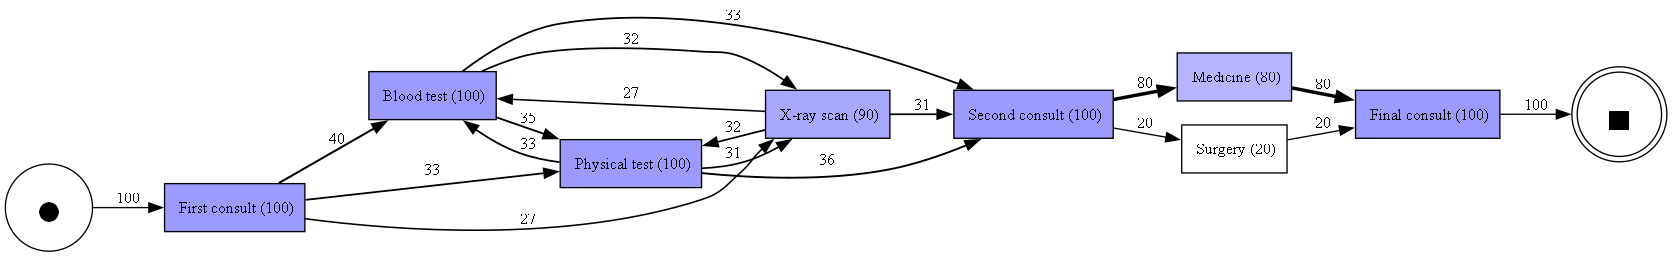

In [18]:
dfg, start_activities, end_activities = pm4py.discover_dfg(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
pm4py.view_dfg(dfg, start_activities, end_activities)

### Use pm4py to build and display a performance (based on time) data-flow-graph (DFG)
#### Performance Data-Flow-Graph (I wasn't able to find a reference for this that wasn't behind a pay-wall, so I'm gonna summarize and you can message me if I'm wrong): The basic idea is to use a DFG to evaluate how the performace of a process was

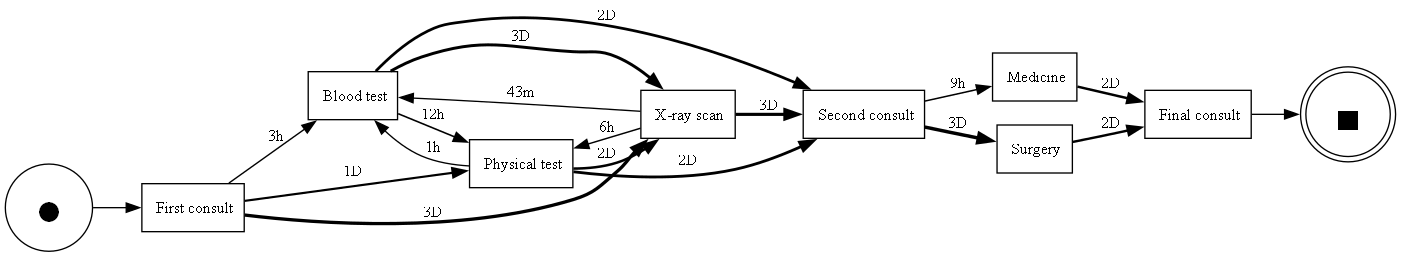

In [19]:
performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

### Use pm4py to build a process tree
#### A process tree is a (mathematical) tree-based model of a process, in which internal vertices represent behavioral control-flow relations and leaves represent process activities.

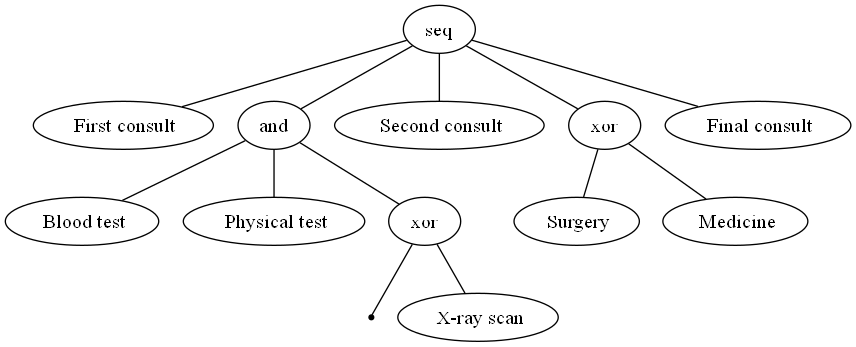

In [20]:
process_tree = pm4py.discover_process_tree_inductive(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
pm4py.view_process_tree(process_tree, rankdir="TB") # rankdir = "LR" (left to right, default) | "TB" (top to bottom)

### Use pm4py to build a Business Process Modeling and Notation (BPMN) diagram

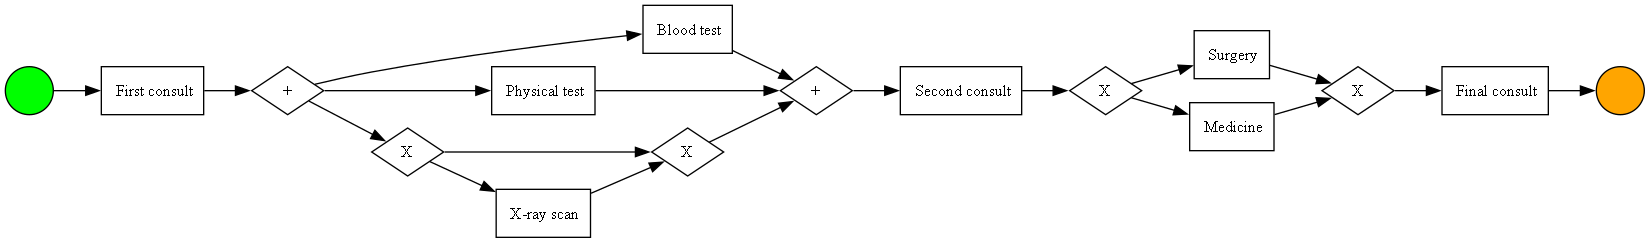

In [21]:
bpmn_graph = pm4py.discover_bpmn_inductive(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
pm4py.view_bpmn(bpmn_graph)

### Use pm4py to build a "heuristics network"

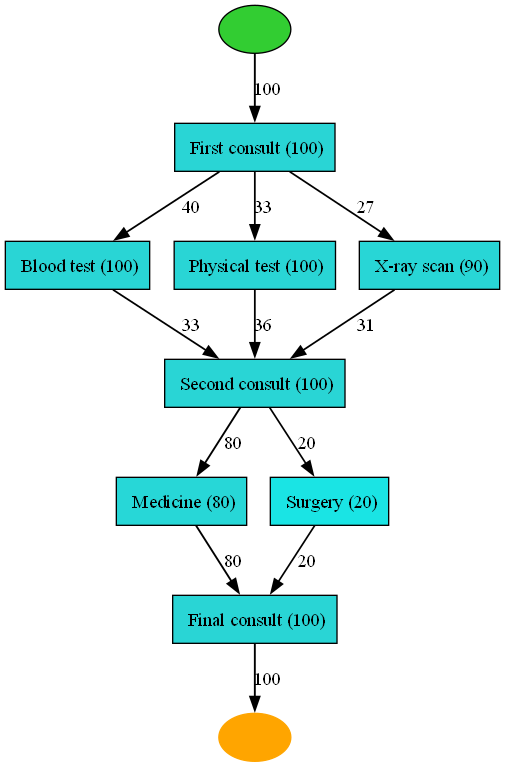

In [22]:
heu_net = pm4py.discover_heuristics_net(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
pm4py.view_heuristics_net(heu_net)

### Use pm4py to build a "dotted plot"
#### Review the "scatter plots" that were generated in the first half of this sheet

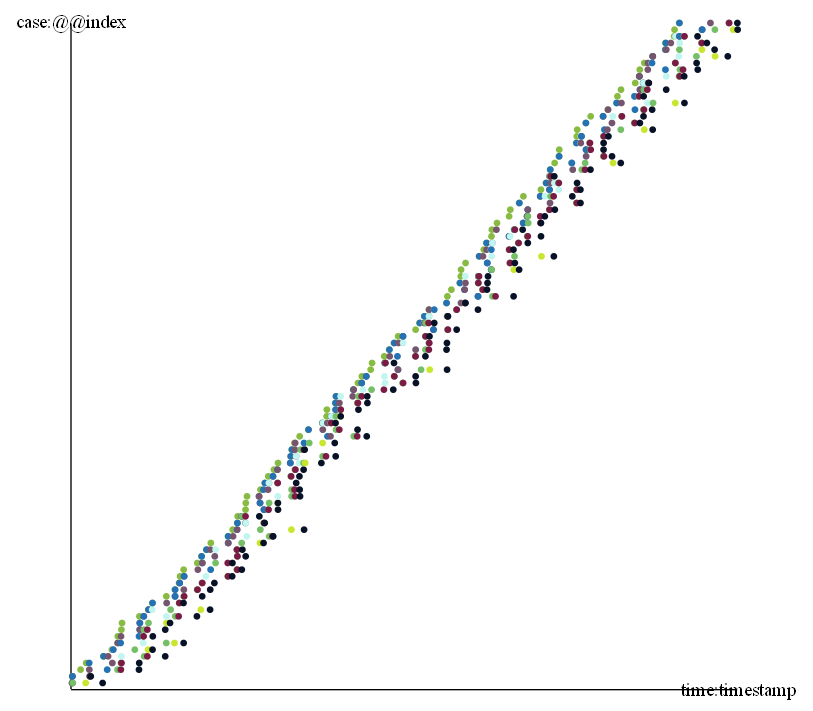

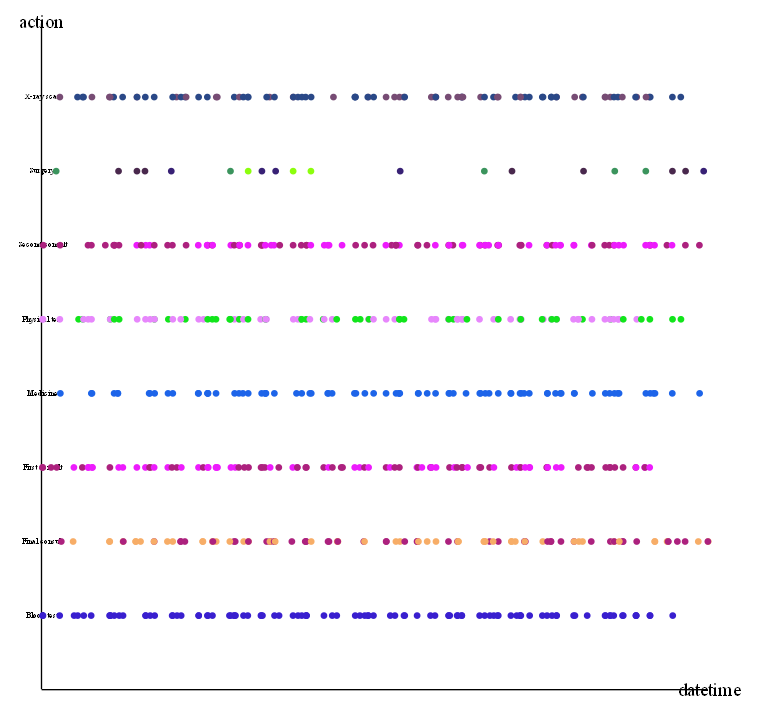

In [23]:
pm4py.view_dotted_chart(patients, show_legend=False)
pm4py.view_dotted_chart(patients, attributes=['datetime', 'action', 'resource'], show_legend=False) # The lengend that this generates is ugly excluding

### Generate a "Case Duration Graph"
#### TO-DO: find a tech/scholarly document to ensure this is what it seems to be

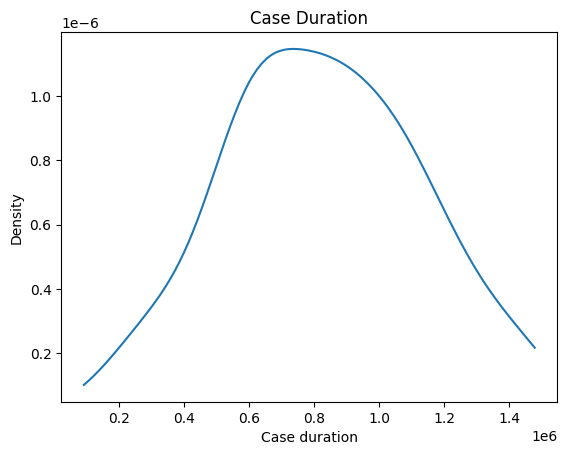

In [24]:
pm4py.view_case_duration_graph(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')

### Generate a "Events per Time graph"
#### TO-DO: find a tech/scholarly document to ensure this is what it seems to be

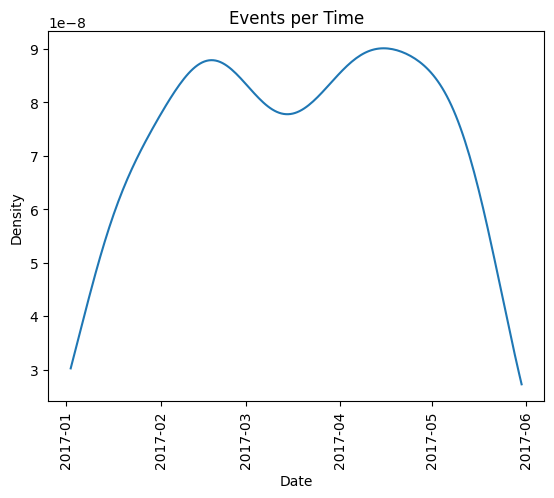

In [25]:
pm4py.view_events_per_time_graph(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')

### Distribution of events based on timestamp

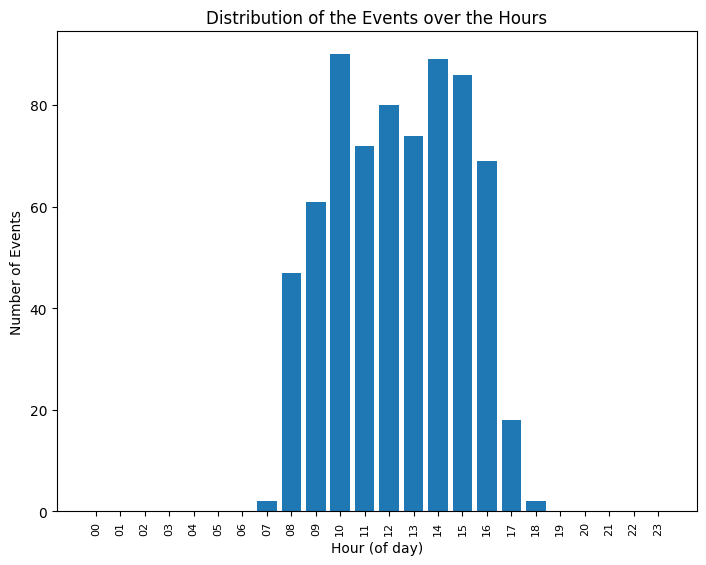

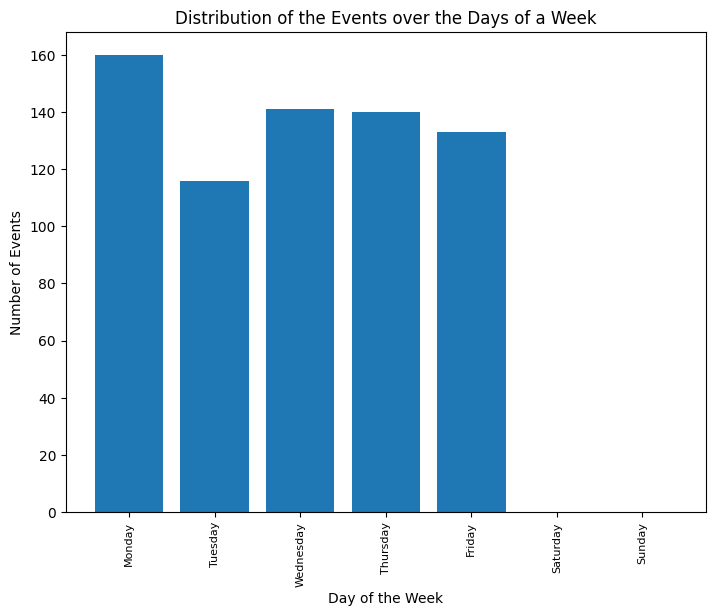

In [27]:
pm4py.view_events_distribution_graph(patients, distr_type='hours', activity_key='action', case_id_key='patient', timestamp_key='datetime')
pm4py.view_events_distribution_graph(patients, distr_type='days_week', activity_key='action', case_id_key='patient', timestamp_key='datetime')

### Views a transition system : A transition system is a mathematical model used to describe the behavior of a system. In AI, transition systems 

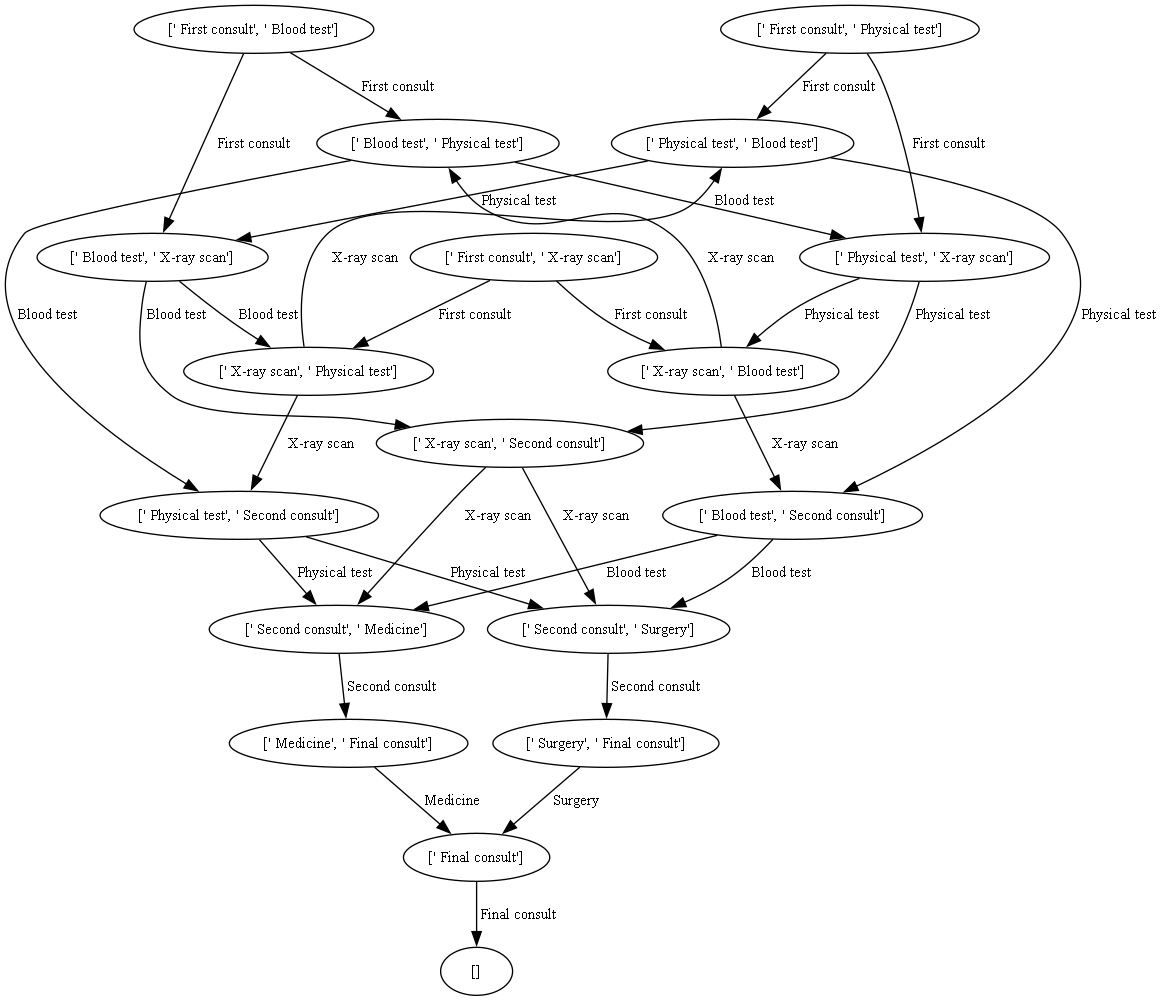

In [31]:
transition_system = pm4py.discover_transition_system(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
pm4py.view_transition_system(transition_system)

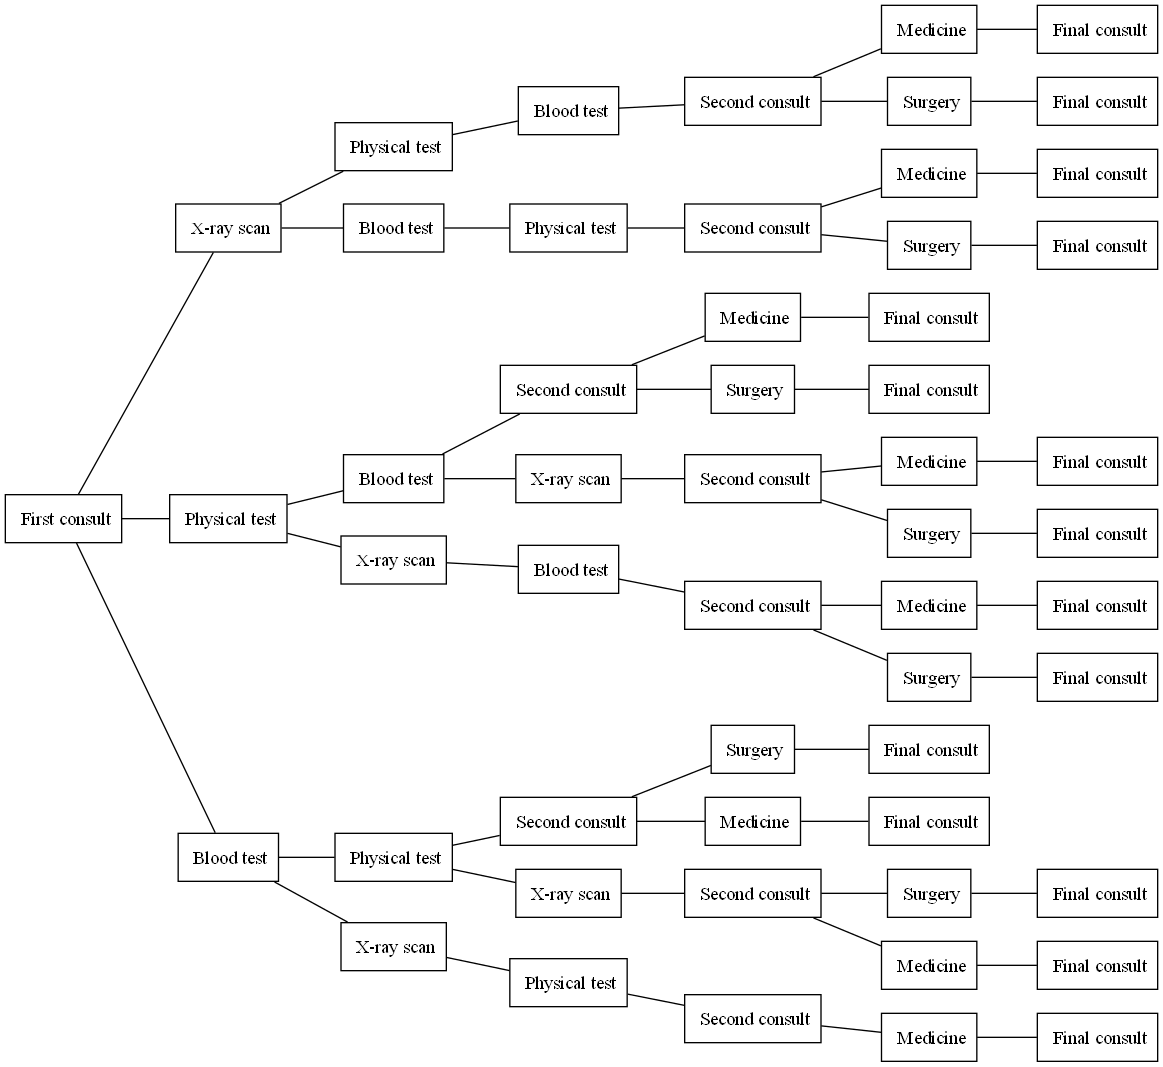

In [32]:
prefix_tree = pm4py.discover_prefix_tree(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
pm4py.view_prefix_tree(prefix_tree)

### Views the alignment table as a figure (?) - I was getting information about D&D

aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

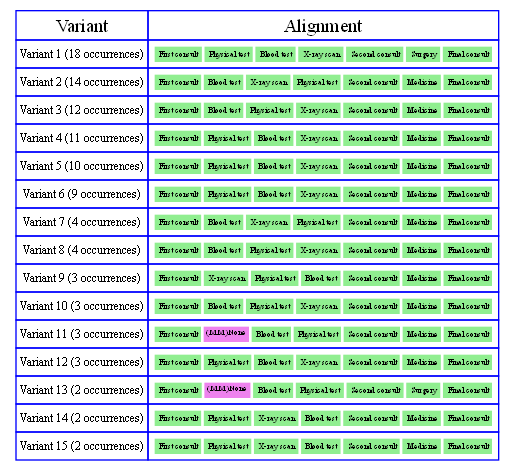

In [33]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(patients, activity_key='action', case_id_key='patient', timestamp_key='datetime')
aligned_traces = pm4py.conformance_diagnostics_alignments(patients, net, initial_marking, final_marking)
pm4py.view_alignments(patients, aligned_traces)

### Views the footprints as a figure

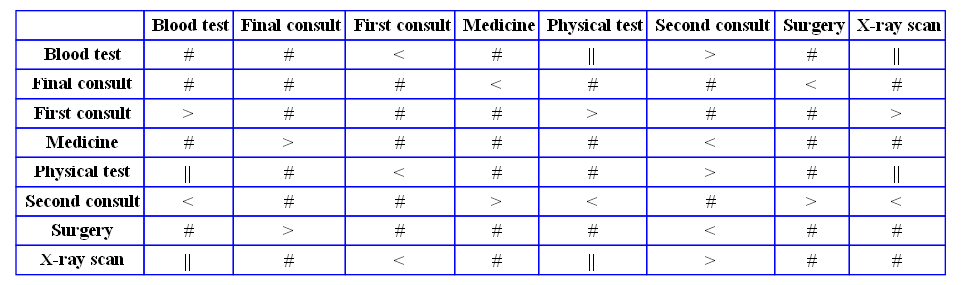

In [34]:
fp_log = pm4py.discover_footprints(patients)
pm4py.view_footprints(fp_log)